In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D



In [26]:
def process_session_log(file_path):
    """
    Processes a session log file and extracts relevant data into a pandas DataFrame.

    Args:
        file_path (str): The path to the session log file.

    Returns:
        pd.DataFrame: A DataFrame containing the extracted data with columns:
            - "Minutes": List of minutes played.
            - "Seconds": List of seconds played.
            - "Milliseconds": List of milliseconds played.
            - "Deaths": List of player deaths.
            - "Game Completed": List of boolean values indicating if the game was completed.

        None: If no valid data is found or an error occurs during processing.

    Raises:
        Exception: If an error occurs while reading or processing the file.
    """
    # Logic to process session log files
    data = {"Minutes": [], "Seconds": [], "Milliseconds": [], "Deaths": [], "Game Completed": []}

    try:
        with open(file_path, 'r') as file:
            for line in file:
                line = line.strip()  # Remove extra whitespace
                if line == "----":
                    break
                if not line:
                    continue
                if ":" in line:
                    key, value = map(str.strip, line.split(":", 1))
                    if key in "Total Time Played (minutes:seconds:milliseconds)":
                         time_parts = value.split(":")[-3:]  # Take only the last 3 parts
                         if len(time_parts) == 3:
                            minutes, seconds, milliseconds = map(int, time_parts)
                            data["Minutes"].append(minutes)
                            data["Seconds"].append(seconds)
                            data["Milliseconds"].append(milliseconds)
                         else:
                            print(f"Invalid time format: {value}. Skipping.")
                    elif key == "Player Died":
                        data["Deaths"].append(int(value))
                    elif key == "Game Completed":
                        data["Game Completed"].append(value.lower() == "true")
                else:
                    print(f"Skipping invalid line: {line}")

        if any(data.values()):
            return pd.DataFrame(data)
        else:
            print(f"No valid data found in {file_path}")
            return None

    except Exception as e:
        print(f"Error processing session log file {file_path}: {e}")
        return None

In [41]:
# Load the CSV file into a DataFrame
#df = process_session_log('Sessionlog/Testie1/NewSessionLog_20241202_133557.csv')
df = pd.read_csv('Sessionlog/Testie1/NewSessionLog_20241202_133557.csv',skiprows=5 ,sep=';')
#index = df[df.apply(lambda row: row.astype(str).str.contains('----').any(), axis=1)].index[0]
#df = df.iloc[index+1:]
print(df.head())

# Specify the column to use for the heat map
xAxis = 'Player Position X'
yAxis = 'Player Position Z'
# Extract relevant columns for the heat map
#df[['Player Position X', 'Player Position Z']] = df['Session Name: NewSessionLog_20241202_133557'].str.split(';', expand=True)[[2, 4]].astype(float)

# Create a pivot table for the heat map
pivot_table = df.pivot_table(index=yAxis, columns=xAxis, aggfunc='size', fill_value=0)

# Create the heat map
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
plt.title(f'Heat Map of  player positions')
plt.show()

       Time State  Player Position X  Player Position Y  Player Position Z  \
0  0:00:132  Game           7.406956           1.818663           7.783700   
1  0:00:298  Game           7.406956           1.533063           7.867865   
2  0:00:463  Game           7.406956           0.936942           7.867865   
3  0:00:631  Game           7.406956           0.137237           7.976945   
4  0:00:798  Game           7.249833          -0.907714           8.113282   

   Monster Position X  Monster Position Y  Monster Position Z  CurrentDeath  
0            7.130001           -3.171168               78.16             0  
1            7.130001           -3.171168               78.16             0  
2            7.130001           -3.171168               78.16             0  
3            7.130001           -3.171168               78.16             0  
4            7.130001           -3.171168               78.16             0  


KeyboardInterrupt: 

In [2]:
import os
import csv

def process_participant_data(groups_file, data_dir, output_dir):
    # Read the Groups.csv file
    participant_groups = {}
    with open(groups_file, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header
        for row in reader:
            participant, group = row
            participant_groups[participant] = group

    # Create output directories for each group
    os.makedirs(output_dir, exist_ok=True)
    group_files = {}
    group_headers_written = {}
    for group in set(participant_groups.values()):
        group_file_path = os.path.join(output_dir, f"{group}.csv")
        group_files[group] = open(group_file_path, mode='w', newline='')
        group_headers_written[group] = False

    # Process each participant folder
    for participant in participant_groups:
        participant_dir = os.path.join(data_dir, participant)
        if os.path.isdir(participant_dir):
            for file_name in os.listdir(participant_dir):
                if file_name.endswith('.csv') and file_name[-10:-4].isdigit():
                    file_path = os.path.join(participant_dir, file_name)
                    with open(file_path, mode='r') as file:
                        reader = csv.reader(file, delimiter=';')
                        if not group_headers_written[participant_groups[participant]]:
                            for _ in range(5):  # Skip first 5 rows
                                next(reader, None)
                            group_headers_written[participant_groups[participant]] = True
                        else:
                            for _ in range(6):  # Skip first 6 rows
                                next(reader, None)
                        group = participant_groups[participant]
                        writer = csv.writer(group_files[group], delimiter=';')
                        for row in reader: # Correct decimal separator localization.
                            row = [cell.replace(',', '.') for cell in row]
                            writer.writerow([participant] + row)

    # Close all group files
    for file in group_files.values():
        file.close()

# Example usage
groups_file = 'Groups.csv'
data_dir = 'Sessionlog'
output_dir = 'ProcessedData'
process_participant_data(groups_file, data_dir, output_dir)

In [7]:
import pandas as pd

# Load your CSV file
file_path = "ProcessedData/Group B.csv"  # Update with your file name
df = pd.read_csv(file_path, delimiter=';')

# Function to convert m:ss:000 to milliseconds
def time_to_milliseconds(time_str):
    minutes, seconds, milliseconds = map(int, time_str.split(":"))
    total_milliseconds = (minutes * 60 * 1000) + (seconds * 1000) + milliseconds
    return total_milliseconds

# Apply the conversion to the Time column
df['Time'] = df['Time'].apply(time_to_milliseconds)

# Save the updated CSV
output_path = "ProcessedData/updated_file_B.csv"  # Update with your desired file name
df.to_csv(output_path, index=False)

print(f"Converted time format saved to {output_path}")


         Testie      Time State  Player Position X  Player Position Y  \
0       Testie2  0:00:165  Game           12.95635           1.796458   
1       Testie2  0:00:331  Game           12.33980           1.491578   
2       Testie2  0:00:498  Game           11.71782           0.940921   
3       Testie2  0:00:632  Game           11.21162           0.163959   
4       Testie2  0:00:798  Game           11.08465          -0.944284   
...         ...       ...   ...                ...                ...   
39337  Testie32  4:43:837  Game           44.69681          -3.682446   
39338  Testie32  4:44:004  Game           45.50375          -3.970003   
39339  Testie32  4:44:156  Game           46.31869          -3.970003   
39340  Testie32  4:44:323  Game           47.15078          -3.970003   
39341  Testie32  4:44:489  Game           47.98036          -3.970003   

       Player Position Z  Monster Position X  Monster Position Y  \
0               7.733848            7.130001           

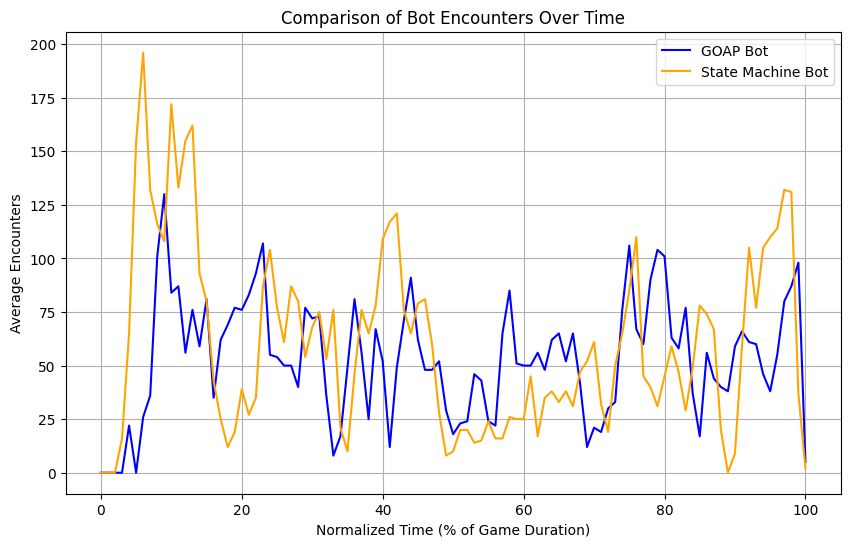

In [ ]:
def process_bot_data(file_path, distance_threshold=10):
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Ensure the required columns are present
    required_columns = ['Testie', 'Time',
                        'Player Position X', 'Player Position Y', 'Player Position Z', 
                        'Monster Position X', 'Monster Position Y', 'Monster Position Z']
    if not all(col in df.columns for col in required_columns):
        raise ValueError("CSV file must contain the required columns.")
    
    distances = np.sqrt(
            (df['Player Position X'] - df['Monster Position X']) ** 2 +
            (df['Player Position Y'] - df['Monster Position Y']) ** 2 +
            (df['Player Position Z'] - df['Monster Position Z']) ** 2
        )
    
    df['Encounter'] = (distances < distance_threshold).astype(int) 

    # Normalize time
    df['NormalizedTime'] = df.groupby('Testie')['Time'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min())
    )

    # count encounters per normalized time
    df['TimeBucket'] = (df['NormalizedTime'] * 100).astype(int)
    encounters_per_bucket = df.groupby('TimeBucket')['Encounter'].mean()
    
    return encounters_per_bucket


def compare_bots(goap_file, state_machine_file):
    goap_data = process_bot_data(goap_file)
    state_machine_data = process_bot_data(state_machine_file)
    
    # Align data for plotting
    all_buckets = sorted(set(goap_data.index).union(set(state_machine_data.index)))
    goap_data = goap_data.reindex(all_buckets, fill_value=0)
    state_machine_data = state_machine_data.reindex(all_buckets, fill_value=0)
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.plot(all_buckets, goap_data, label="GOAP Bot", color="blue")
    plt.plot(all_buckets, state_machine_data, label="State Machine Bot", color="orange")
    plt.xlabel("Normalized Time (% of Game Duration)")
    plt.ylabel("Average Encounters")
    plt.title("Comparison of Bot Encounters Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

# File paths
goap_file = "ProcessedData/updated_file_A.csv"
state_machine_file = "ProcessedData/updated_file_B.csv"

# Run the comparison
compare_bots(goap_file, state_machine_file)


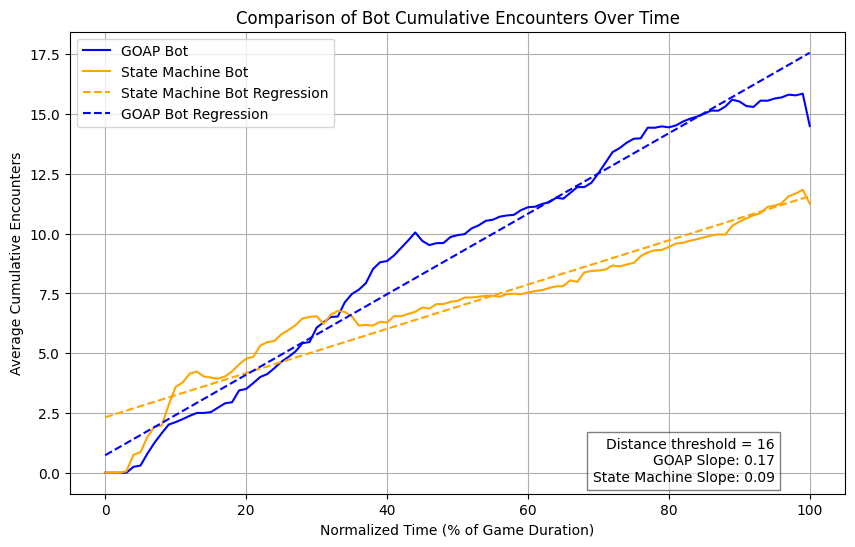

In [40]:
def process_bot_data_cumulative(file_path, distance_threshold=16):
    # Load CSV
    df = pd.read_csv(file_path)
    
    # Ensure required columns are present
    required_columns = ['Testie', 'Time', 
                        'Player Position X', 'Player Position Y', 'Player Position Z', 
                        'Monster Position X', 'Monster Position Y', 'Monster Position Z']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"{file_path} is missing required columns.")
    
    # Calculate distances
    distances = np.sqrt(
        (df['Player Position X'] - df['Monster Position X']) ** 2 +
        (df['Player Position Y'] - df['Monster Position Y']) ** 2 +
        (df['Player Position Z'] - df['Monster Position Z']) ** 2
    )
    
    # Determine encounters (account for separation before recounting)
    df['IsInContact'] = (distances < distance_threshold).astype(int)
    df['Encounter'] = df.groupby('Testie')['IsInContact'].diff().fillna(0).apply(lambda x: 1 if x == 1 else 0)
    
    # Normalize time (to game progress percentage)
    df['NormalizedTime'] = df.groupby('Testie')['Time'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min())
    )
    
    # Calculate cumulative encounters
    df['TimeBucket'] = (df['NormalizedTime'] * 100).astype(int)
    cumulative_df = df.groupby(['Testie', 'TimeBucket'])['Encounter'].sum().groupby(level=0).cumsum()
    cumulative_df = cumulative_df.reset_index()  # Flatten index for merging
    
    # Merge back with original DataFrame
    df = df.merge(cumulative_df, on=['Testie', 'TimeBucket'], how='left', suffixes=('', '_Cumulative'))
    
    # Average cumulative encounters at each normalized time bucket
    average_cumulative = df.groupby('TimeBucket')['Encounter_Cumulative'].mean()
    
    return average_cumulative


def compare_bots_cumulative(goap_file, state_machine_file):
    goap_data = process_bot_data_cumulative(goap_file, distance)
    state_machine_data = process_bot_data_cumulative(state_machine_file, distance)
    
    # Align data for plotting
    all_buckets = sorted(set(goap_data.index).union(set(state_machine_data.index)))
    goap_data = goap_data.reindex(all_buckets, fill_value=0)
    state_machine_data = state_machine_data.reindex(all_buckets, fill_value=0)
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.plot(all_buckets, goap_data, label="GOAP Bot", color="blue")
    plt.plot(all_buckets, state_machine_data, label="State Machine Bot", color="orange")

    # Linear regression for State Machine Bot
    state_machine_slope, state_machine_intercept = np.polyfit(all_buckets, state_machine_data, 1)
    state_machine_regression_line = state_machine_slope * np.array(all_buckets) + state_machine_intercept
    plt.plot(all_buckets, state_machine_regression_line, color="orange", linestyle="--", label="State Machine Bot Regression")

    # Linear regression for GOAP
    goap_slope, goap_intercept = np.polyfit(all_buckets, goap_data, 1)
    goap_regression_line = goap_slope * np.array(all_buckets) + goap_intercept
    plt.plot(all_buckets, goap_regression_line, color="blue", linestyle="--", label="GOAP Bot Regression")

    plt.xlabel("Normalized Time (% of Game Duration)")
    plt.ylabel("Average Cumulative Encounters")
    plt.title("Comparison of Bot Cumulative Encounters Over Time")
    plt.legend()
    plt.grid(True)
    plt.text(
    95, 0.5,  # Position in axes coordinates (x, y)
    f"Distance threshold = {distance}\nGOAP Slope: {goap_slope:.2f}\nState Machine Slope: {state_machine_slope:.2f}",
    bbox=dict(facecolor='white', alpha=0.5),
    verticalalignment='center',  # Center vertically
    horizontalalignment='right'  # Align to the left edge
)

    plt.show()

# File paths
goap_file = "ProcessedData/updated_file_A.csv"
state_machine_file = "ProcessedData/updated_file_B.csv"
distance = 16
# Run the comparison
compare_bots_cumulative(goap_file, state_machine_file)


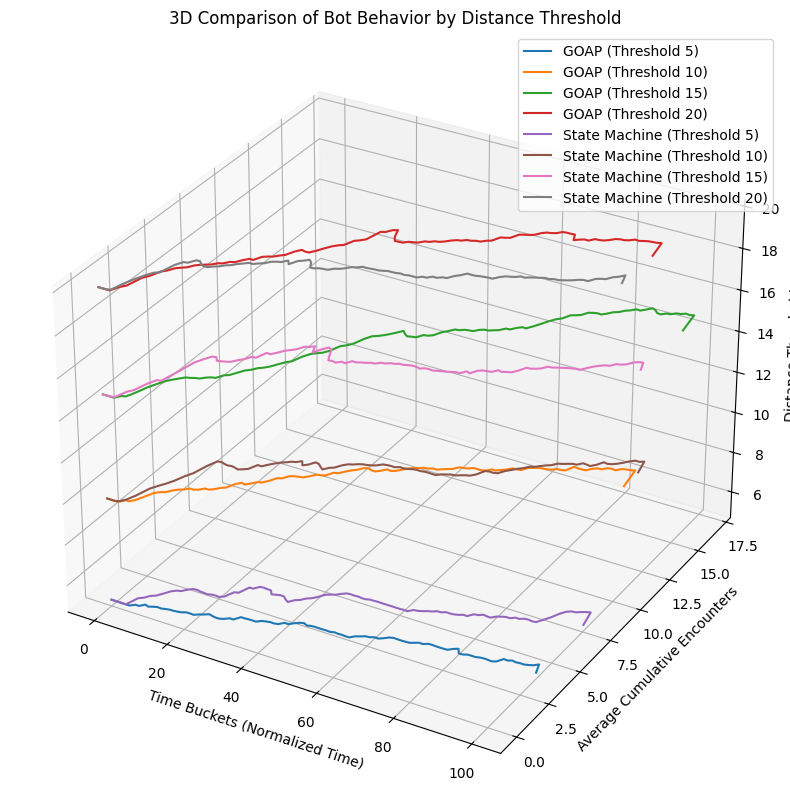

In [21]:
def compare_bots_3d(file_goap, file_state_machine, distance_thresholds):
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    for bot_type, file_path in [('GOAP', file_goap), ('State Machine', file_state_machine)]:
        for i, threshold in enumerate(distance_thresholds):
            # Process data for the current threshold
            average_cumulative = process_bot_data_cumulative(file_path, distance_threshold=threshold)
            
            # Extract x, y, and z values
            time_buckets = average_cumulative.index
            avg_cumulative_encounters = average_cumulative.values
            distance_values = [threshold] * len(time_buckets)
            
            # Plot the line in 3D space
            ax.plot(time_buckets, avg_cumulative_encounters, distance_values, label=f"{bot_type} (Threshold {threshold})")
    
    # Add labels and legend
    ax.set_xlabel('Time Buckets (Normalized Time)')
    ax.set_ylabel('Average Cumulative Encounters')
    ax.set_zlabel('Distance Threshold')
    ax.set_title('3D Comparison of Bot Behavior by Distance Threshold')
    ax.legend()
    plt.show()
distance_thresholds = [5, 10, 15, 20]
compare_bots_3d("ProcessedData/updated_file_A.csv", "ProcessedData/updated_file_B.csv", distance_thresholds)
